# Train ANN Model Acid OER

In [1]:
import random
import sklearn
import os
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn import ensemble
from sklearn.tree import ExtraTreeRegressor
from sklearn import svm
from sklearn import neighbors
from sklearn import tree
from sklearn import ensemble
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score
from scipy.stats import pearsonr, spearmanr, kendalltau
from sklearn.model_selection import LeaveOneOut
import pandas as pd
#%matplotlib 
###########import packages##########
import catboost
import xgboost
import lightgbm
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import *
import pickle
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import  *
###########import packages##########
import tensorflow as tf
import keras
from keras import optimizers
from keras import regularizers
from keras import backend as K
from keras.callbacks import EarlyStopping
from keras.callbacks import TensorBoard
from keras.constraints import max_norm
from keras.models import Sequential 
from keras.layers import Dense 
from keras.layers import Dropout 
from keras.models import Model
from keras.layers import BatchNormalization
from keras.wrappers.scikit_learn import KerasClassifier 
from keras.wrappers.scikit_learn import KerasRegressor
from keras.constraints import maxnorm 
# from keras.wrappers import scikit_learn
from scikeras.wrappers import KerasClassifier, KerasRegressor
###########loading data##########
loo = LeaveOneOut()
import matplotlib.pyplot as plt

# ANN needs scalers to regularize input

In [2]:
from sklearn.preprocessing import *
from sklearn.model_selection import train_test_split
Minmaxsc  = MinMaxScaler(feature_range=(0, 1))
Minmaxsc2  = MinMaxScaler(feature_range=(0, 1))
Stdsc  = StandardScaler()
Stdsc2  = StandardScaler()
MAsc  = MaxAbsScaler()
MAsc2  = MaxAbsScaler()
Rsc  = RobustScaler()
Rsc2  = RobustScaler()

In [3]:
###########wrapping root mean square error for later calls##########
def compute_mae_mse_rmse_r2_r_rs_tau(target,prediction):
    target = target.flatten()  # reshape to 1D array
    prediction = prediction.flatten()  # reshape to 1D array
    error = target - prediction
    squaredError = error ** 2
    absError = np.abs(error)
    mae = np.mean(absError)  # 平均绝对误差MAE
    mse = np.mean(squaredError)  # 均方误差MSE
    rmse = np.sqrt(mse)  # 均方根误差RMSE
    r2 = r2_score(prediction,target)  # R2 score
    r, _ = pearsonr(target, prediction)  # Pearson's correlation coefficient (R)
    rs, _ = spearmanr(target, prediction)  # Spearman's rank correlation coefficient (Rs)
    tau, _ = kendalltau(target, prediction)  # Kendall's rank correlation coefficient (Tau)
    return mae, mse, rmse, r2, r, rs, tau
def gridsearch(model,param,algorithm_name,X,y):
    grid = GridSearchCV(model,param_grid=param,scoring='neg_root_mean_squared_error',cv=5,n_jobs=-1,verbose=2)
    grid.fit(X,y)
    best_model=grid.best_estimator_
    best_score=grid.best_score_
    print('Best Regressor:',grid.best_params_,'Best Score:', best_score)
    return best_model,best_score
seed=219

In [4]:
import keras.backend as K

def create_dropout_predict_function(model, dropout):
    """
    Create a predict function that enables dropout during prediction time.
    """
    # Get the layers and their rates
    layers = [l for l in model.layers if hasattr(l, 'rate')]

    # Define a function to apply dropouta
    def apply_dropout():
        for layer in layers:
            if hasattr(layer, 'rate'):
                layer.rate = dropout

    # Define a function to predict with dropout
    def predict_with_dropout(x):
        apply_dropout()
        return model(x)

    return K.function([model.input], [predict_with_dropout(model.input)])
import time

def predict_with_dropout(model, x, n_iterations=1000000):
    predictions = []
    start_time = time.time()  # Start timer
    for i in range(n_iterations):
        predictions.append(dropout_predict([x]))
    predictions = np.concatenate(predictions, axis=0)
    mean_predictions = predictions.mean(axis=0)
    std_predictions = predictions.std(axis=0)
    end_time = time.time()  # End timer
    elapsed_time = end_time - start_time  # Calculate elapsed time

    print(f"Time taken: {elapsed_time} seconds")
    return mean_predictions, std_predictions




In [5]:
def predict_and_print_with_uncertainty(algorithm_name, model, random_seed):
    X_train,X_test,y_train,y_test=train_test_split(data_input_full_ANN,data_output_full_ANN,test_size=0.05,random_state=random_seed)
    
    # Make predictions with dropout
    mean_pred_train, std_pred_train = predict_with_dropout(model, X_train)
    mean_pred_test, std_pred_test = predict_with_dropout(model, X_test)
    mean_pred_all, std_pred_all = predict_with_dropout(model, data_input_full_ANN)

    # Convert predictions back to original scale
    mean_pred_train = Stdsc2.inverse_transform(mean_pred_train.mean(axis=1).reshape(-1, 1))
    mean_pred_test = Stdsc2.inverse_transform(mean_pred_test.mean(axis=1).reshape(-1, 1))
    mean_pred_all = Stdsc2.inverse_transform(mean_pred_all.mean(axis=1).reshape(-1, 1))
    real_train=Stdsc2.inverse_transform(y_train)
    real_test=Stdsc2.inverse_transform(y_test)
    real_all=Stdsc2.inverse_transform(data_output_full_ANN)
    
    # Print metrics
    print(compute_mae_mse_rmse_r2_r_rs_tau(mean_pred_all,real_all))
    print(compute_mae_mse_rmse_r2_r_rs_tau(mean_pred_test,real_test))
    print(compute_mae_mse_rmse_r2_r_rs_tau(mean_pred_train,real_train))
    
    # Convert standard deviations back to original scale
    std_pred_train_orig = std_pred_train * Stdsc2.scale_
    std_pred_test_orig = std_pred_test * Stdsc2.scale_
    
        # Plot predictions
    fig=plt.figure()
    ax = fig.add_subplot(111)
    x_y_x=np.arange(150,700,1)
    x_y_y=np.arange(150,700,1)
    ax.scatter(mean_pred_train,real_train,c='blue',label='Train',alpha=0.25)
    ax.scatter(mean_pred_test,real_test,c='red',label='Test',alpha=0.75)
    ax.plot(x_y_x,x_y_y,c='black')
    plt.legend()
    plt.xlabel('Predicted_Overpotential (mV)')
    plt.ylabel('Real_Overpotential (mV)')
    plt.savefig(algorithm_name+'_Acid_OER.png')

    # Create a new figure with two subplots side by side
    fig, axs = plt.subplots(2, 2, figsize=(12, 12))

    # Adjust the spacing between subplots
    plt.subplots_adjust(wspace=0.4, hspace=0.4)

    # Create an array of indices for bar plot
    indices_test = np.arange(len(mean_pred_test))
    indices_train = np.arange(len(mean_pred_train))

    # Plot standard deviations for test data
    axs[0, 0].bar(indices_test, std_pred_test_orig.flatten(), color='red', alpha=0.75, label='Test')

    # Plot standard deviations for train data
    axs[0, 1].bar(indices_train, std_pred_train_orig.flatten(), color='blue', alpha=0.75, label='Train')

    # Add horizontal line for average standard deviation
    avg_std_test = np.mean(std_pred_test_orig)
    avg_std_train = np.mean(std_pred_train_orig)
    axs[0, 0].axhline(avg_std_test, color='purple', linestyle='--', label=f'Avg Std (Test): {avg_std_test:.2e}')
    axs[0, 1].axhline(avg_std_train, color='purple', linestyle='--', label=f'Avg Std (Train): {avg_std_train:.2e}')

    # Set labels and legend
    for ax in axs[0]:
        ax.legend()
        ax.set_xlabel('Sample Index')
        ax.set_ylabel('Standard Deviation of Predictions')

    # Set y-limits to be the same for both plots
    ylim = max(axs[0, 0].get_ylim()[1], axs[0, 1].get_ylim()[1])
    for ax in axs[0]:
        ax.set_ylim(0, ylim)

    # Plot histograms of standard deviations
    axs[1, 0].hist(std_pred_test_orig.flatten(), bins=50, color='red', alpha=0.75)
    axs[1, 0].set_title('Histogram of Standard Deviations (Test)')
    axs[1, 0].set_xlabel('Standard Deviation')
    axs[1, 0].set_ylabel('Frequency')

    axs[1, 1].hist(std_pred_train_orig.flatten(), bins=50, color='blue', alpha=0.75)
    axs[1, 1].set_title('Histogram of Standard Deviations (Train)')
    axs[1, 1].set_xlabel('Standard Deviation')
    axs[1, 1].set_ylabel('Frequency')
    
    # Rotate xticks by 45 degrees
    for ax in axs.flat:
        plt.setp(ax.get_xticklabels(), rotation=45)
    
    # Save figure
    plt.savefig(algorithm_name+'_Acid_OER_std_combined.png')

In [6]:
def create_ANN_model_3layer(X,learning_rate,regular_term=0.001,neuron_number=50,drop_out_rate=0.1):
    regularizer=keras.regularizers.l2(regular_term)
    model = Sequential() 
    model.add(Dense(neuron_number, input_dim=X.shape[1], kernel_initializer='random_normal',
                    bias_initializer='random_normal',activation='relu',kernel_regularizer=regularizer)) 
    model.add(Dropout(drop_out_rate))
    model.add(Dense(neuron_number, input_dim=neuron_number, kernel_initializer='random_normal',
                    bias_initializer='random_normal',activation='relu',kernel_regularizer=regularizer)) 
    model.add(Dropout(drop_out_rate))
    model.add(Dense(neuron_number, input_dim=neuron_number, kernel_initializer='random_normal',
                    bias_initializer='random_normal',activation='relu',kernel_regularizer=regularizer)) 
    model.add(Dropout(drop_out_rate))    
    model.add(Dense(neuron_number, input_dim=neuron_number, kernel_initializer='random_normal',
                    bias_initializer='random_normal',activation='relu',kernel_regularizer=regularizer)) 
    model.add(Dropout(drop_out_rate))
    model.add(Dense(1, input_dim=neuron_number, activation='linear'))
    adam=optimizers.Adam(learning_rate)
    model.compile(loss='mae')
    return model

In [7]:
def create_ANN_model_3layer_CV(X,learning_rate,regular_term=0.001,neuron_number=50,drop_out_rate=0.1):
    regularizer=keras.regularizers.l2(regular_term)
    model = Sequential() 
    model.add(Dense(neuron_number, input_dim=X.shape[1], kernel_initializer='random_normal',
                    bias_initializer='random_normal',activation='relu',kernel_regularizer=regularizer)) 
    model.add(Dropout(drop_out_rate))
    model.add(Dense(neuron_number, input_dim=neuron_number, kernel_initializer='random_normal',
                    bias_initializer='random_normal',activation='relu',kernel_regularizer=regularizer)) 
    model.add(Dropout(drop_out_rate))
    model.add(Dense(neuron_number, input_dim=neuron_number, kernel_initializer='random_normal',
                    bias_initializer='random_normal',activation='relu',kernel_regularizer=regularizer)) 
    model.add(Dropout(drop_out_rate))    
    model.add(Dense(neuron_number, input_dim=neuron_number, kernel_initializer='random_normal',
                    bias_initializer='random_normal',activation='relu',kernel_regularizer=regularizer)) 
    model.add(Dropout(drop_out_rate))
    model.add(Dense(1, input_dim=neuron_number, activation='linear'))
    adam=optimizers.Adam(learning_rate)
    model.compile(loss='mae')
    return model

In [8]:
database=pd.read_csv('processed_database.csv')

In [9]:
data_output_full=database.iloc[:,1]
data_input_full=database.iloc[:,2:]

In [10]:
data_input_full_ANN=Stdsc.fit_transform(data_input_full)
data_output_full_ANN=Stdsc2.fit_transform(np.array(data_output_full).reshape(-1,1))

In [ ]:
from sklearn.model_selection import KFold
model_ANNRegressor_CV= KerasRegressor(build_fn=create_ANN_model_3layer_CV(X=data_input_full,learning_rate=0.001), 
                                   epochs=50, batch_size=32, verbose=0)
def predict_and_print_cv(model, n_splits=5):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=15)
    results_all, results_test, results_train = [], [], []

    for train_index, test_index in kfold.split(data_input_full_ANN):
        X_train, X_test = data_input_full_ANN[train_index], data_input_full_ANN[test_index]
        y_train, y_test = data_output_full_ANN[train_index], data_output_full_ANN[test_index]

        model.fit(X_train, y_train)  # assuming your model needs to be retrained in each fold

        pred_train = Stdsc2.inverse_transform(model.predict(X_train))
        pred_test = Stdsc2.inverse_transform(model.predict(X_test))
        real_train = Stdsc2.inverse_transform(y_train)
        real_test = Stdsc2.inverse_transform(y_test)

        pred_all = Stdsc2.inverse_transform(model.predict(data_input_full_ANN))
        real_all = Stdsc2.inverse_transform(data_output_full_ANN)

        results_all.append(compute_mae_mse_rmse_r2_r_rs_tau(pred_all, real_all))
        results_test.append(compute_mae_mse_rmse_r2_r_rs_tau(pred_test, real_test))
        results_train.append(compute_mae_mse_rmse_r2_r_rs_tau(pred_train, real_train))

    # Compute average metrics over all folds
    avg_results_all = np.mean(results_all, axis=0)
    avg_results_test = np.mean(results_test, axis=0)
    avg_results_train = np.mean(results_train, axis=0)

    print("Average metrics over all data: ", avg_results_all)
    print("Average metrics over test data: ", avg_results_test)
    print("Average metrics over train data: ", avg_results_train)

    return avg_results_all, avg_results_test, avg_results_train


In [ ]:
model_ANNRegressor= KerasRegressor(build_fn=create_ANN_model_3layer(X=data_input_full,learning_rate=0.001), verbose=0)

In [ ]:
batch_size_list = [32,64]
optimizers_list=['adam','sgd']
epochs_list=[50,100,150,200]
param_ann = dict(batch_size=batch_size_list, 
                 epochs=epochs_list,
                optimizer=optimizers_list
                )

In [ ]:
os.environ['PYTHONHASHSEED']=str(seed)
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
X_train_ANN,X_test_ANN,y_train_ANN,y_test_ANN=train_test_split(data_input_full_ANN,data_output_full_ANN,test_size=0.05,random_state=seed)
ANN_3layer,ANN_3layer_score=gridsearch(model_ANNRegressor,param_ann,'Artificial Neural Network_3layer',X_train_ANN,y_train_ANN)
predict_and_print('Artificial Neural Network_3layer',ANN_3layer,seed)

In [ ]:
ANN_3layer.model_.save('Acid_OER.h5')

In [ ]:
# Call the function for getting CV average metrics
avg_results_all, avg_results_test, avg_results_train = predict_and_print_cv(model_ANNRegressor_CV)

Time taken: 2607.640872478485 seconds
Time taken: 2187.323960542679 seconds
Time taken: 3095.1072709560394 seconds
(20.26405949379081, 1883.744622254539, 43.40212693238131, 0.7693592037670458, 0.8816481251587772, 0.9214635826851832, 0.7947161275100586)
(47.12360064188639, 3203.883243791866, 56.60285543850121, 0.20006105474010327, 0.6783758073555108, 0.6259243741321049, 0.4218209707263814)
(18.815455027376668, 1812.5461348008407, 42.57400773712572, 0.7828414828986727, 0.8917726511638064, 0.9453600724925282, 0.8282625977739815)


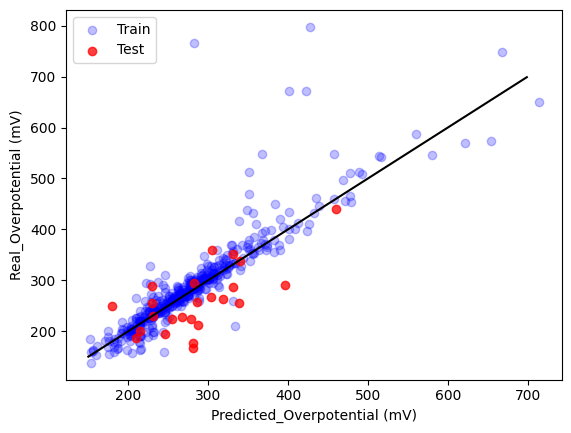

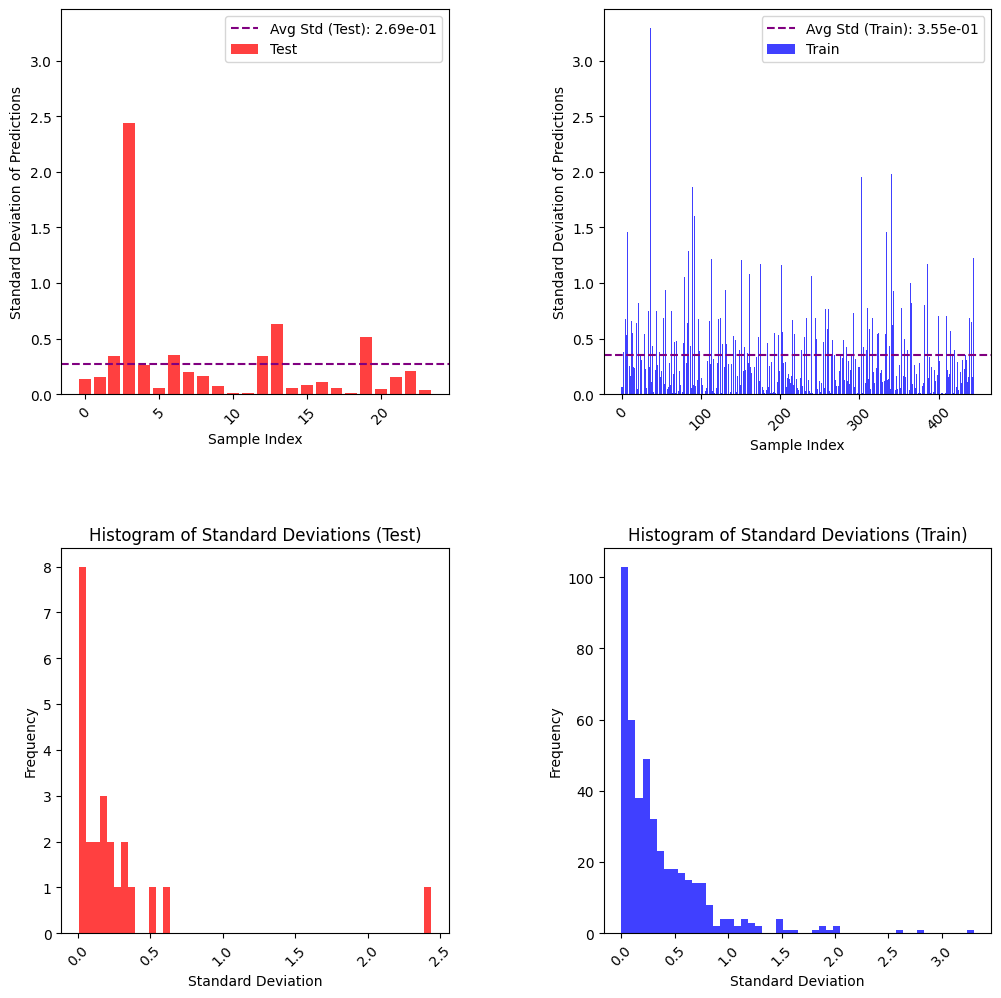

In [11]:
ANN_3layer=keras.models.load_model("Acid_OER.h5")
dropout_predict = create_dropout_predict_function(ANN_3layer, 0.25)
predict_and_print_with_uncertainty('Artificial Neural Network_3layer',ANN_3layer,seed)